In [1]:
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
with open('/Users/naveenverma/Desktop/NewStart/Dataset/Industrial_and_Scientific_5.json', 'r') as file:
    data = [json.loads(line) for line in file]

sentiments = [2 if d["overall"] > 3 else (1 if d["overall"] == 3 else 0) for d in data]
texts = [d.get("reviewText", "") for d in data]

In [3]:
def clean_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

def tokenize_text(text):
    return word_tokenize(text)

stop_words = set(stopwords.words('english'))

def preprocess(text):
    cleaned_text = clean_text(text)
    tokens = tokenize_text(cleaned_text)
    return ' '.join([token for token in tokens if token not in stop_words])

In [4]:
processed_texts = [preprocess(text) for text in texts]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(processed_texts)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(processed_texts)
padded_sequences = pad_sequences(sequences)

In [5]:
X = np.array(padded_sequences)
y = np.array(sentiments)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

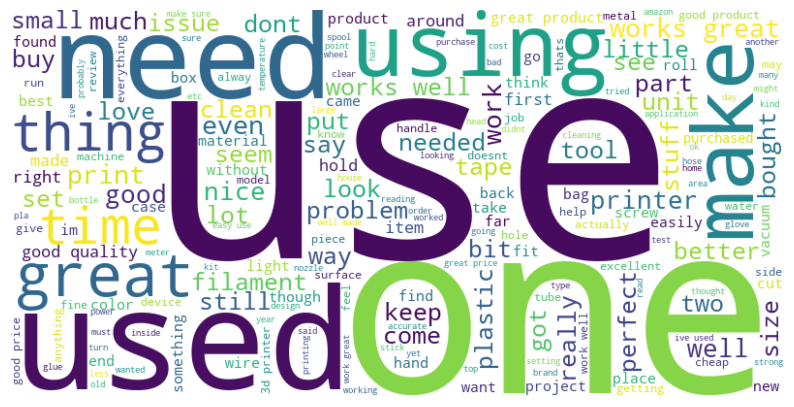

In [7]:
from wordcloud import WordCloud

all_text = ' '.join(processed_texts)

wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', preprocessor=lambda x: x, analyzer=lambda x: x)
X_tfidf = tfidf_vectorizer.fit_transform(processed_texts)
y_tfidf = np.array(sentiments)

/Users/naveenverma/venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:531: UserWarning: The parameter 'preprocessor' will not be used since 'analyzer' is callable'
  warnings.warn(
/Users/naveenverma/venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:547: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [9]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
feature_importance = rf_model.feature_importances_
top_n = 10
important_features_indices = np.argsort(feature_importance)[::-1][:top_n]
important_features_words = [word for word, index in word_index.items() if index in important_features_indices]
print(f"Top {top_n} Important Features: {important_features_words}")

Accuracy: 0.9004216672072657
Top 10 Important Features: ['jig', 'shield', 'broom', 'electricity', 'mild', 'droppers', 'belts', 'prototyping', 'hictop', 'dreamer']


In [38]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_dense = X_tfidf.toarray()
X_train, X_test, y_train, y_test = train_test_split(X_dense, y_tfidf, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
feature_importance = rf_model.feature_importances_
top_n = 10
important_features_indices = np.argsort(feature_importance)[::-1][:top_n]
important_features_words = [word for word, index in word_index.items() if index in important_features_indices]
print(f"Top {top_n} Important Features: {important_features_words}")

Accuracy: 0.9012001297437561
Top 10 Important Features: ['would', 'price', 'time', 'nice', 'filament', 'dont', 'better', 'im', 'buy']


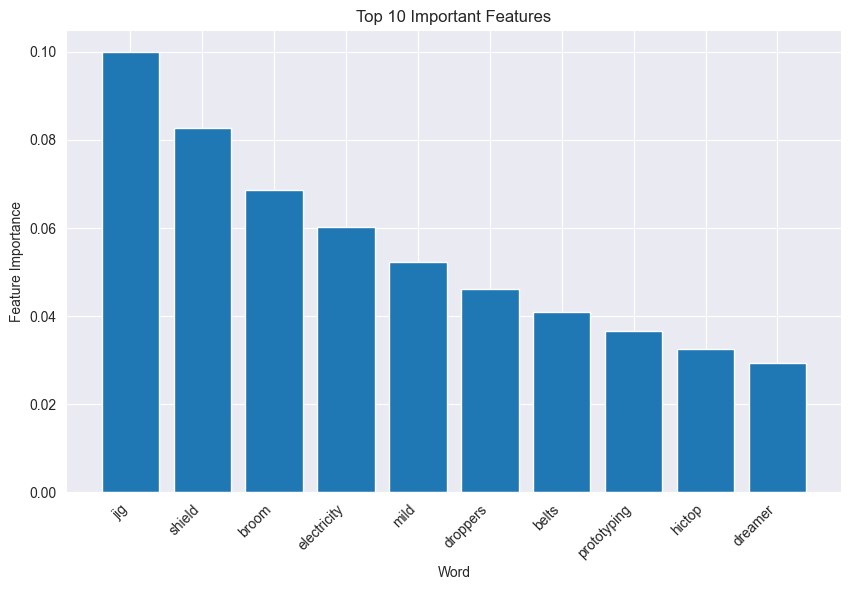

In [15]:
plt.figure(figsize=(10, 6))
plt.bar(important_features_words, feature_importance[important_features_indices])
plt.title('Top 10 Important Features')
plt.xlabel('Word')
plt.ylabel('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [76]:
sample_size = 20000
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [77]:
embedding_dim = 100
max_length = X.shape[1]

In [78]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
batch_size = 32
epochs = 5

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])
y_pred_lstm = np.argmax(lstm_model.predict(X_test), axis=1)
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix (LSTM):")
print(conf_matrix_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average=None)
recall_lstm = recall_score(y_test, y_pred_lstm, average=None)
f1_lstm = f1_score(y_test, y_pred_lstm, average=None)
print(f"Precision for each class (LSTM): {precision_lstm}")
print(f"Recall for each class (LSTM): {recall_lstm}")
print(f"F1 Score for each class (LSTM): {f1_lstm}")

Epoch 1/5
400/400 [==============================] - 686s 2s/step - loss: 0.3993 - accuracy: 0.8861 - val_loss: 0.3491 - val_accuracy: 0.8888
Epoch 2/5


/Users/naveenverma/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 687s 2s/step - loss: 0.2669 - accuracy: 0.9097 - val_loss: 0.3503 - val_accuracy: 0.8872
Epoch 3/5
400/400 [==============================] - 698s 2s/step - loss: 0.1733 - accuracy: 0.9410 - val_loss: 0.4014 - val_accuracy: 0.8778
Epoch 4/5
125/125 [==============================] - 56s 450ms/step
Confusion Matrix (LSTM):
[[  49    0  195]
 [  10    0  219]
 [  17    0 3510]]
Precision for each class (LSTM): [0.64473684 0.         0.89449541]
Recall for each class (LSTM): [0.20081967 0.         0.99518004]
F1 Score for each class (LSTM): [0.30625    0.         0.94215542]


/Users/naveenverma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


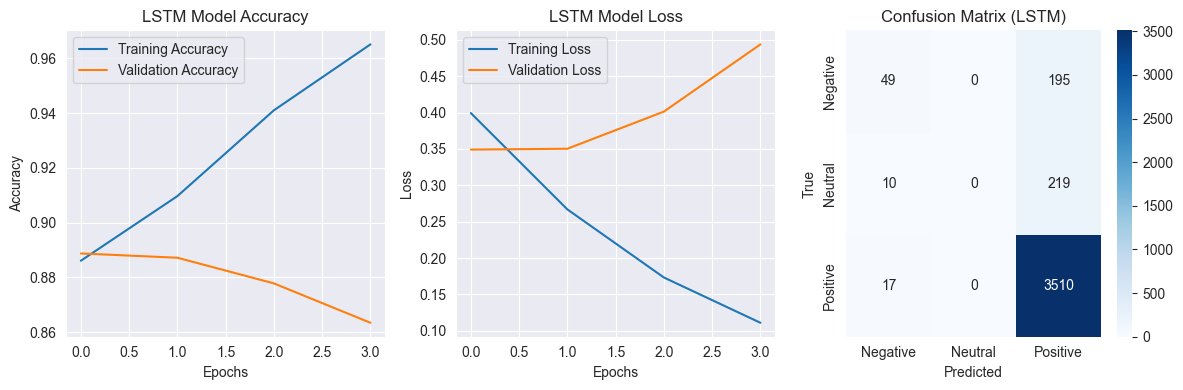

In [80]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')
plt.legend()

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix (LSTM)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [81]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_resampled, y_resampled)

y_pred_rf = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(conf_matrix_rf)

precision_rf = precision_score(y_test, y_pred_rf, average=None)
recall_rf = recall_score(y_test, y_pred_rf, average=None)
f1_rf = f1_score(y_test, y_pred_rf, average=None)

print(f"Precision for each class (Random Forest): {precision_rf}")
print(f"Recall for each class (Random Forest): {recall_rf}")
print(f"F1 Score for each class (Random Forest): {f1_rf}")

Accuracy: 0.80775
Confusion Matrix (Random Forest):
[[  45   17  182]
 [  18   37  174]
 [ 218  160 3149]]
Precision for each class (Random Forest): [0.16014235 0.1728972  0.89843081]
Recall for each class (Random Forest): [0.18442623 0.16157205 0.89282676]
F1 Score for each class (Random Forest): [0.17142857 0.16704289 0.89562002]


In [82]:
sequences_resampled = tokenizer.texts_to_sequences(processed_texts)
padded_sequences_resampled = pad_sequences(sequences_resampled)

In [83]:
X_resampled_lstm = np.array(padded_sequences_resampled)
y_resampled_lstm = np.array(sentiments)
sample_size = 20000
X_sample, _, y_sample, _ = train_test_split(X_resampled_lstm, y_resampled_lstm, train_size=sample_size, stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [84]:
embedding_dim = 100
max_length = X_resampled_lstm.shape[1]

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_length))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size_lstm = 32
epochs_lstm = 5

early_stopping_lstm = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint_lstm = ModelCheckpoint('best_lstm_model.h5', save_best_only=True)

history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs_lstm, batch_size=batch_size_lstm, validation_split=0.2, callbacks=[early_stopping_lstm, model_checkpoint_lstm])

y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype("int32")

conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix (LSTM):")
print(conf_matrix_lstm)

precision_lstm = precision_score(y_test, y_pred_lstm, average=None)
recall_lstm = recall_score(y_test, y_pred_lstm, average=None)
f1_lstm = f1_score(y_test, y_pred_lstm, average=None)

print(f"Precision for each class (LSTM): {precision_lstm}")
print(f"Recall for each class (LSTM): {recall_lstm}")
print(f"F1 Score for each class (LSTM): {f1_lstm}")

Epoch 1/5
400/400 [==============================] - 658s 2s/step - loss: -26.4190 - accuracy: 0.0579 - val_loss: -43.6401 - val_accuracy: 0.0572
Epoch 2/5


/Users/naveenverma/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


400/400 [==============================] - 629s 2s/step - loss: -59.9645 - accuracy: 0.0579 - val_loss: -75.5142 - val_accuracy: 0.0572
Epoch 3/5
400/400 [==============================] - 627s 2s/step - loss: -92.1825 - accuracy: 0.0579 - val_loss: -107.6479 - val_accuracy: 0.0572
Epoch 4/5
400/400 [==============================] - 639s 2s/step - loss: -124.3206 - accuracy: 0.0579 - val_loss: -139.4344 - val_accuracy: 0.0572
Epoch 5/5
125/125 [==============================] - 47s 372ms/step
Confusion Matrix (LSTM):
[[   0  244    0]
 [   0  229    0]
 [   0 3527    0]]
Precision for each class (LSTM): [0.      0.05725 0.     ]
Recall for each class (LSTM): [0. 1. 0.]
F1 Score for each class (LSTM): [0.         0.10829983 0.        ]


/Users/naveenverma/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42)

class_counts = np.bincount(y_train)
class_weights = len(y_train) / (len(class_counts) * class_counts)
class_weight_dict = dict(enumerate(class_weights))

smote = SMOTE(random_state=42)
X_train_lstm, y_train_lstm = smote.fit_resample(X_train, y_train)

X_train_lstm, y_train_lstm = shuffle(X_train_lstm, y_train_lstm, random_state=42)

history_lstm = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=epochs_lstm, batch_size=batch_size_lstm,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping_lstm, model_checkpoint_lstm]
)

Epoch 1/5
1328/1328 [==============================] - 2251s 2s/step - loss: 57.8259 - accuracy: 0.3492 - val_loss: -4.6528 - val_accuracy: 0.0640
Epoch 2/5
1328/1328 [==============================] - 2233s 2s/step - loss: 1.6067 - accuracy: 0.4295 - val_loss: -9.1656 - val_accuracy: 0.0658
Epoch 3/5
1328/1328 [==============================] - 2166s 2s/step - loss: 0.3782 - accuracy: 0.4736 - val_loss: -20.7888 - val_accuracy: 0.0658
Epoch 4/5
1328/1328 [==============================] - 2136s 2s/step - loss: -0.5114 - accuracy: 0.4858 - val_loss: -27.7480 - val_accuracy: 0.0672
Epoch 5/5
1328/1328 [==============================] - 2178s 2s/step - loss: -3.3577 - accuracy: 0.5172 - val_loss: -46.1799 - val_accuracy: 0.0670


In [67]:
positive_indices = np.where(y_tfidf == 2)[0]
negative_indices = np.where(y_tfidf == 0)[0]
neutral_indices = np.where(y_tfidf == 1)[0]

min_samples = min(len(positive_indices), len(negative_indices), len(neutral_indices))
print(min_samples)

selected_positive_indices = np.random.choice(positive_indices, min_samples, replace=False)
selected_negative_indices = np.random.choice(negative_indices, min_samples, replace=False)
selected_neutral_indices = np.random.choice(neutral_indices, min_samples, replace=False)

selected_indices = np.concatenate([selected_positive_indices, selected_negative_indices, selected_neutral_indices])
print(len(selected_indices))

X_balanced = X_tfidf[selected_indices]
y_balanced = y_tfidf[selected_indices]

X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

4418
13254


In [69]:
X_balanced = X_tfidf[selected_indices]
y_balanced = y_tfidf[selected_indices]

X_balanced_dense = X_balanced.toarray()

processed_balanced_texts = [preprocess(text) for text in [texts[i] for i in selected_indices]]

sequences_balanced = tokenizer.texts_to_sequences(processed_balanced_texts)
padded_sequences_balanced = pad_sequences(sequences_balanced, maxlen=max_length)

X_balanced_test = np.array(padded_sequences_balanced)
y_balanced_test = np.array(y_balanced)

test_loss, test_accuracy = lstm_model.evaluate(X_balanced_test, y_balanced_test)

print(f"Test Accuracy on Balanced Data: {test_accuracy}")

415/415 [==============================] - 2s 5ms/step - loss: 1.0993 - accuracy: 0.3014
Test Accuracy on Balanced Data: 0.3014184534549713


In [71]:
remaining_indices = np.setdiff1d(np.arange(len(texts)), selected_indices)

X_train_remaining = X_tfidf[remaining_indices]
y_train_remaining = y_tfidf[remaining_indices]

X_train_remaining_dense = X_train_remaining.toarray()

processed_train_texts = [preprocess(text) for text in [texts[i] for i in remaining_indices]]

sequences_train = tokenizer.texts_to_sequences(processed_train_texts)
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_length)

X_train = np.array(padded_sequences_train)
y_train = np.array(y_train_remaining)

lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)



Epoch 1/5
798/798 [==============================] - 23s 28ms/step - loss: 0.0152 - accuracy: 0.9988 - val_loss: 0.0055 - val_accuracy: 0.9994
Epoch 2/5
798/798 [==============================] - 22s 28ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.0056 - val_accuracy: 0.9994
Epoch 3/5
798/798 [==============================] - 22s 28ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.0053 - val_accuracy: 0.9994
Epoch 4/5
798/798 [==============================] - 22s 28ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0059 - val_accuracy: 0.9994
Epoch 5/5
798/798 [==============================] - 22s 28ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0063 - val_accuracy: 0.9994


In [72]:
from sklearn.metrics.pairwise import cosine_similarity

X_remaining = X_tfidf[remaining_indices]
X_selected = X_tfidf[selected_indices]

cosine_sim = cosine_similarity(X_remaining, X_selected)

print(cosine_sim)

[[0.67390898 0.73052908 0.30511851 ... 0.88896748 0.92401969 0.83867035]
 [0.66983277 0.69019033 0.30722257 ... 0.89202553 0.90269288 0.83556849]
 [0.45270017 0.37728969 0.19384642 ... 0.56395654 0.5015571  0.55285677]
 ...
 [0.65432123 0.63103269 0.34418459 ... 0.9195316  0.91097755 0.83256245]
 [0.60820952 0.65837814 0.30221246 ... 0.90343772 0.90767528 0.78678811]
 [0.58575338 0.56101002 0.36132563 ... 0.85580073 0.8357105  0.84468553]]


In [73]:
print(len(cosine_sim))

63817


In [75]:
processed_selected_texts = [preprocess(text) for text in [texts[i] for i in selected_indices]]

sequences_selected = tokenizer.texts_to_sequences(processed_selected_texts)
padded_sequences_selected = pad_sequences(sequences_selected, maxlen=max_length)

X_selected_test = np.array(padded_sequences_selected)
y_selected_test = np.array(y_balanced)

selected_test_loss, selected_test_accuracy = lstm_model.evaluate(X_selected_test, y_selected_test)

print(f"Accuracy on Selected Test Set: {selected_test_accuracy}")

processed_texts = [preprocess(text) for text in texts]

sequences_full = tokenizer.texts_to_sequences(processed_texts)
padded_sequences_full = pad_sequences(sequences_full, maxlen=max_length)

X_full = np.array(padded_sequences_full)
y_full = np.array(sentiments)

full_dataset_loss, full_dataset_accuracy = lstm_model.evaluate(X_full, y_full)

print(f"Accuracy on Full Dataset: {full_dataset_accuracy}")

415/415 [==============================] - 2s 5ms/step - loss: 7.8760 - accuracy: 0.3333
Accuracy on Selected Test Set: 0.3333333432674408
2409/2409 [==============================] - 11s 5ms/step - loss: 1.3564 - accuracy: 0.8850
Accuracy on Full Dataset: 0.8850410580635071


In [86]:
lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

test_loss, test_accuracy = lstm_model.evaluate(X_balanced, y_balanced)

print(f"Accuracy on Balanced Test Set: {test_accuracy}")


Epoch 1/5
400/400 [==============================] - 639s 2s/step - loss: 0.2957 - accuracy: 0.9015 - val_loss: 0.2898 - val_accuracy: 0.9016
Epoch 2/5
400/400 [==============================] - 662s 2s/step - loss: 0.2008 - accuracy: 0.9268 - val_loss: 0.3006 - val_accuracy: 0.9047
Epoch 3/5
400/400 [==============================] - 669s 2s/step - loss: 0.1344 - accuracy: 0.9560 - val_loss: 0.3571 - val_accuracy: 0.9022
Epoch 4/5
400/400 [==============================] - 662s 2s/step - loss: 0.0879 - accuracy: 0.9744 - val_loss: 0.4017 - val_accuracy: 0.8847
Epoch 5/5
400/400 [==============================] - 663s 2s/step - loss: 0.0616 - accuracy: 0.9827 - val_loss: 0.4528 - val_accuracy: 0.8884


2023-12-10 21:23:39.380399: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at serialize_sparse_op.cc:388 : INVALID_ARGUMENT: indices[1] = [0,17] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.




InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[1] = [0,17] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse] name: 